# HANDWRITTEN DIGIT RECOGNITION

In this project, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

### Step zero: Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
!pip3 install tqdm
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import f1_score
# from sklearn.metrics import classification_report, confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [ ]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST(root='./data', download=True, train=True, transform=transform) #TODO use datasets.MNIST
testset = datasets.MNIST(root='./data', download=True, train=False, transform=transform) #TODO

In [ ]:
print(len(trainset))
print(len(testset))

60000
10000


In [ ]:
valid_size = 0.2

train_length = len(trainset)

indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size*train_length))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
print(len(train_sampler))
print(len(valid_sampler))

48000
12000


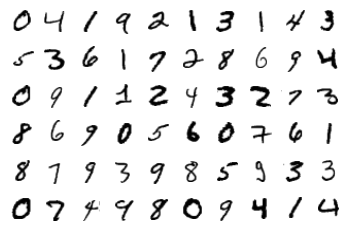

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(trainset[index][0][0], cmap='gray_r')

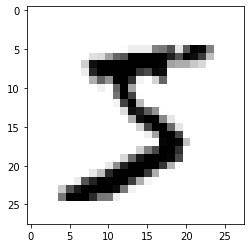

In [ ]:
plt.imshow(trainset[0][0][0], cmap="gray_r")

In [ ]:
batch_size = 64

In [ ]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, num_workers=2)

trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1, sampler=train_sampler, num_workers=2)

validloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64, sampler = valid_sampler, num_workers=2)

validloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1, sampler = valid_sampler, num_workers=2)

testloader_minibatch = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2) #TODO

testloader_stochastic = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2) #TODO    

print(len(trainloader_minibatch), len(trainloader_stochastic), len(validloader_minibatch), len(validloader_stochastic), len(testloader_minibatch), len(testloader_stochastic))

750 48000 188 12000 157 10000


In [ ]:
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()


  0%|          | 1/750 [08:51<110:30:50, 531.18s/it]

  0%|          | 1/750 [00:00<02:27,  5.06it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self):
        super(SimpleMLP,self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self,x):
        x = x.view(-1, 784)
        output = torch.relu(self.fc1(x))
        output = torch.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [ ]:
# configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [ ]:
# code here
def SGD_optimizer(model, learning_rate):
  SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  return SGD_optimizer

def SGD_momentum_optimizer(model, learning_rate, m):
  SGD_momentum_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=m)
  return SGD_momentum_optimizer

def SGD_L2_optimizer(model, learning_rate, wd):
  SGD_L2_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)
  return SGD_L2_optimizer

def RMS_optimizer(model, learning_rate):
  RMS_optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
  return RMS_optimizer

def Adam_optimizer(model, learning_rate):
  Adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return Adam_optimizer

### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [ ]:
def train_Model(model, optimizer, epochs):
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  # epochs = epochs
  # optimizer = optimizer
  result = []
  # loss_dict={'train':[], 'valid':[]}
  trainloss_list = []
  validloss_list = []
  trainAcc_list = []
  validAcc_list = []

  # minValidLoss = np.Inf

  for epoch in range(epochs):
      train_loss=0.0
      valid_loss=0.0
      train_accurate = 0
      valid_accurate = 0

      # training phase
      model.train()
      for images, labels in trainloader_minibatch:
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          optimizer.zero_grad()
          output = model(images)
          loss = criterion(output,labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          pred1 = output.argmax(dim=1)
          train_accurate += torch.sum((pred1==labels).int())

      # validation phase
      model.eval()
      for images, labels in validloader_minibatch:
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          output = model(images)
          loss = criterion(output,labels)
          valid_loss += loss.item()
      
          pred2 = output.argmax(dim=1)
          valid_accurate += torch.sum((pred2==labels).int())

      Accuracy_train = 100 * (train_accurate/len(train_sampler))
      Accuracy_valid = 100 * (valid_accurate/len(valid_sampler))

      train_loss = train_loss/len(trainloader_minibatch)
      valid_loss = valid_loss/len(validloader_minibatch)

      trainloss_list.append(train_loss)
      validloss_list.append(valid_loss)
      trainAcc_list.append(Accuracy_train)
      validAcc_list.append(Accuracy_valid)

  print("Training Loss: ", train_loss ,"\tValidation Loss: ", valid_loss)
  print(f'Train Accuracy: {Accuracy_train} \tValidation Accuracy: {Accuracy_valid}\n')

  result.extend([trainloss_list, validloss_list, trainAcc_list, validAcc_list])
  return result

In [ ]:
def test_Model(model):
    correct = 0
    test_loss = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    result = []

    model.eval()
    test_accurate = 0
    for images, labels in testloader_minibatch:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = criterion(output,labels)
            test_loss += loss.item()
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(labels.data.view_as(pred)))


            pred = output.argmax(dim=1)
            test_accurate += torch.sum((pred==labels).int())

    test_loss = test_loss/len(testloader_minibatch)
    Accuracy_test = 100 * (test_accurate/len(testset))

    print(f'Test Loss: {test_loss} Test Accuracy: {Accuracy_test}')
    f1score = f1_score(labels, pred, average='weighted')

    result.extend([test_loss, Accuracy_test, f1score])
    return result

In [ ]:
from tabulate import tabulate
def table(m_loss, m_testLoss):
  print(tabulate([[m_loss[0][9], m_loss[2][9], m_loss[1][9], m_loss[3][9], m_testLoss[0], m_testLoss[1], m_testLoss[2]]], headers=['Training Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy', 'Test Loss', 'Test Accuracy', 'F1 Score']))

In [ ]:
def plotLoss_Accuracy(m_loss, epoch):
  x = np.linspace(1,epoch,num=10)
  
  fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
  #Training Loss plot
  
  ax1.plot(x,m_loss[0],label="Training Loss")
  ax1.plot(x,m_loss[1],label="Validation Loss")
  ax1.set_title("Loss Plot")
  # ax1.axis("off")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend()

  #Trainging Accuracy
  # ax2 = fig.add_subplot(1,2,2)

  ax2.plot(x,m_loss[2],label="Training Accuracy")
  ax2.plot(x,m_loss[3],label="Validation Accuracy")
  ax2.set_title("Accuracy Plot")
  # ax2.axis("off")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  ax2.legend()

In [ ]:
epochs = 10

Using SGD Optimizer

In [ ]:
model_SGD = SimpleMLP().to(device)
SgdOptimizer = SGD_optimizer(model_SGD, 0.1)

In [ ]:
m1_loss = train_Model(model_SGD, SgdOptimizer, epochs)

Training Loss:  0.04062026747968048 	Validation Loss:  0.10235360574393355
Train Accuracy: 98.76457977294922 	Validation Accuracy: 97.21666717529297



In [ ]:
m1_testLoss = test_Model(model_SGD)

Test Loss: 0.08378201955781099 Test Accuracy: 97.3699951171875


In [ ]:
table(m1_loss, m1_testLoss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0406203           98.7646           0.102354                97.2167     0.083782            97.37           1


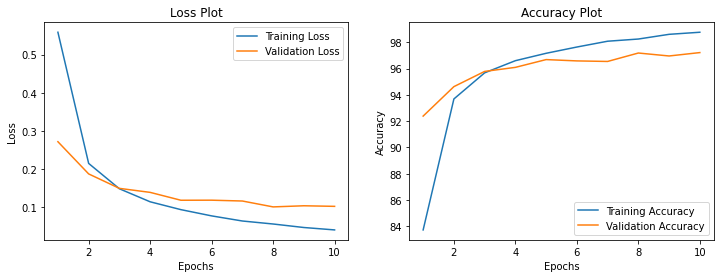

In [ ]:
plotLoss_Accuracy(m1_loss, epochs)

Using SGD with momentum Optimizer

In [ ]:
model_SGDM = SimpleMLP().to(device)
SgdMomemtumOptimizer = SGD_momentum_optimizer(model_SGDM, 0.1, 0.5)

In [ ]:
m2_loss = train_Model(model_SGDM, SgdMomemtumOptimizer, epochs)

Training Loss:  0.019513605811982415 	Validation Loss:  0.0993293224071633
Train Accuracy: 99.40208435058594 	Validation Accuracy: 97.49166107177734



In [ ]:
m2_testLoss = test_Model(model_SGDM)

Test Loss: 0.08343445676101585 Test Accuracy: 97.5199966430664


In [ ]:
table(m2_loss, m2_testLoss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0195136           99.4021          0.0993293                97.4917    0.0834345            97.52           1


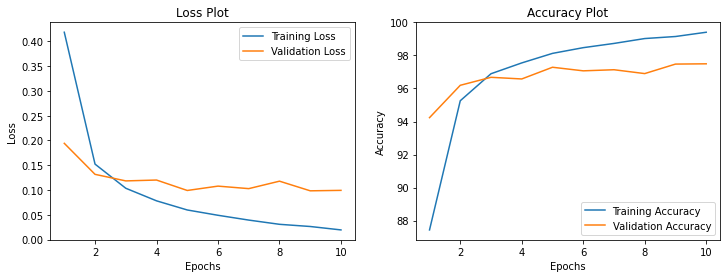

In [ ]:
plotLoss_Accuracy(m2_loss, epochs)

Using SGD L2 optimizer

In [ ]:
model_L2 = SimpleMLP().to(device)
SgdL2Optimizer = SGD_L2_optimizer(model_L2, 0.1, 1e-5)

In [ ]:
m3_loss = train_Model(model_L2, SgdL2Optimizer, epochs)

Training Loss:  0.03923406701721251 	Validation Loss:  0.09531717728129885
Train Accuracy: 98.81458282470703 	Validation Accuracy: 97.29166412353516



In [ ]:
m3_testLoss = test_Model(model_L2)

Test Loss: 0.0781494680299738 Test Accuracy: 97.66999816894531


In [ ]:
table(m3_loss, m3_testLoss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0392341           98.8146          0.0953172                97.2917    0.0781495            97.67    0.943452


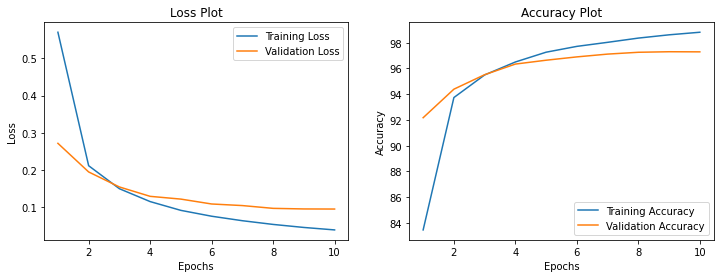

In [ ]:
plotLoss_Accuracy(m3_loss, epochs)

Using RMSprop optimizer

In [ ]:
model_RMS = SimpleMLP().to(device)
RmsOptimizer = RMS_optimizer(model_RMS, 0.01)

In [ ]:
m4_loss = train_Model(model_RMS, RmsOptimizer, epochs)

Training Loss:  0.11454339286285298 	Validation Loss:  0.22758647016289227
Train Accuracy: 96.82708740234375 	Validation Accuracy: 95.70000457763672



In [ ]:
m4_testLoss = test_Model(model_RMS)

Test Loss: 0.24581291035832067 Test Accuracy: 95.66000366210938


In [ ]:
table(m4_loss, m4_testLoss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
       0.114543           96.8271           0.227586                   95.7     0.245813            95.66       0.875


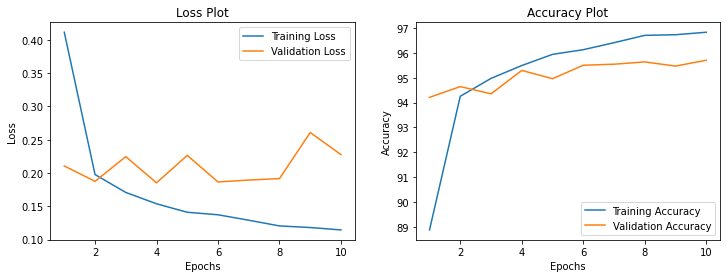

In [ ]:
plotLoss_Accuracy(m4_loss, epochs)

Using Adam optimizer

In [ ]:
model_AD = SimpleMLP().to(device)
AdamOptimizer = Adam_optimizer(model_AD, 0.001)

In [ ]:
m5_loss = train_Model(model_AD, AdamOptimizer, epochs)

Training Loss:  0.02219876001162144 	Validation Loss:  0.11383595662265818
Train Accuracy: 99.28333282470703 	Validation Accuracy: 97.24166107177734



In [ ]:
m5_testLoss = test_Model(model_AD)

Test Loss: 0.10287454764983041 Test Accuracy: 97.54999542236328


In [ ]:
table(m5_loss, m5_testLoss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0221988           99.2833           0.113836                97.2417     0.102875            97.55           1


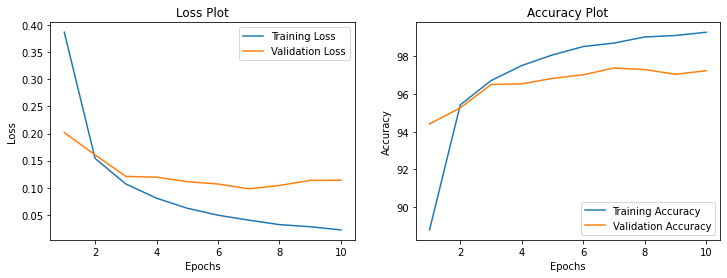

In [ ]:
plotLoss_Accuracy(m5_loss, epochs)

### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

Here, I am taking Adam optimizer for training model

In [ ]:
def linearLR():
  scheduler = torch.optim.lr_scheduler.LinearLR(AdamOptimizer, start_factor = 0.5, total_iters = 8)
  return scheduler

In [ ]:
def MultiplicativeLR(epoch):
  lmbda = lambda epoch: 0.65 ** epoch
  scheduler = torch.optim.lr_scheduler.MultiplicativeLR(AdamOptimizer, lr_lambda=lmbda)
  return scheduler

In [ ]:
def train_Model_sch(model, optimizer, epochs, scheduler):

  result = []
  trainloss_list = []
  validloss_list = []
  trainAcc_list = []
  validAcc_list = []

  # minValidLoss = np.Inf

  for epoch in range(epochs):
      train_loss=0.0
      valid_loss=0.0
      train_accurate = 0
      valid_accurate = 0

      # training phase
      model.train()
      for images, labels in trainloader_minibatch:
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          optimizer.zero_grad()
          output = model(images)
          loss = criterion(output,labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          pred1 = output.argmax(dim=1)
          train_accurate += torch.sum((pred1==labels).int())

      # validation phase
      model.eval()
      for images, labels in validloader_minibatch:
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          output = model(images)
          loss = criterion(output,labels)
          valid_loss += loss.item()
      
          pred2 = output.argmax(dim=1)
          valid_accurate += torch.sum((pred2==labels).int())

      scheduler.step()
      Accuracy_train = 100 * (train_accurate/len(train_sampler))
      Accuracy_valid = 100 * (valid_accurate/len(valid_sampler))

      train_loss = train_loss/len(trainloader_minibatch)
      valid_loss = valid_loss/len(validloader_minibatch)

      trainloss_list.append(train_loss)
      validloss_list.append(valid_loss)
      trainAcc_list.append(Accuracy_train)
      validAcc_list.append(Accuracy_valid)

  print("Training Loss: ", train_loss ,"\tValidation Loss: ", valid_loss)
  print(f'\nTrain Accuracy: {Accuracy_train} \tValidation Accuracy: {Accuracy_valid}\n')

  result.extend([trainloss_list, validloss_list, trainAcc_list, validAcc_list])
  return result

In [ ]:
model6 = SimpleMLP().to(device)
AdamOptimizer1 = Adam_optimizer(model6, 0.001)

In [ ]:
scheduler1 = MultiplicativeLR(epoch=10)

In [ ]:
scheduler2 = linearLR()

In [ ]:
m5_loss_sch1 = train_Model_sch(model6, AdamOptimizer1, epochs, scheduler1)

Training Loss:  0.023530681885235633 	Validation Loss:  0.11255511230766832

Train Accuracy: 99.25 	Validation Accuracy: 97.33333587646484



In [ ]:
m5_Testloss_sch1 = test_Model(model6)

Test Loss: 0.0894547526789147 Test Accuracy: 97.64999389648438


In [ ]:
table(m5_loss_sch1, m5_Testloss_sch1)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0235307             99.25           0.112555                97.3333    0.0894548            97.65    0.935714


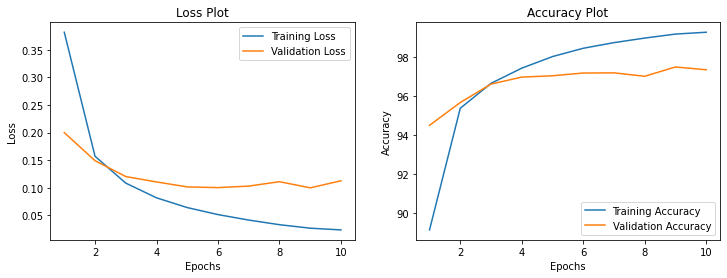

In [ ]:
plotLoss_Accuracy(m5_loss_sch1, epoch=10)

In [ ]:
m5_loss_sch2 = train_Model_sch(model6, AdamOptimizer1, epochs, scheduler2)

Training Loss:  0.012025176267733816 	Validation Loss:  0.14710302954812932

Train Accuracy: 99.59791564941406 	Validation Accuracy: 97.34166717529297



In [ ]:
m5_Testloss_sch2 = test_Model(model6)

Test Loss: 0.1218091611078849 Test Accuracy: 97.66999816894531


In [ ]:
table(m5_loss_sch2, m5_Testloss_sch2)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0120252           99.5979           0.147103                97.3417     0.121809            97.67           1


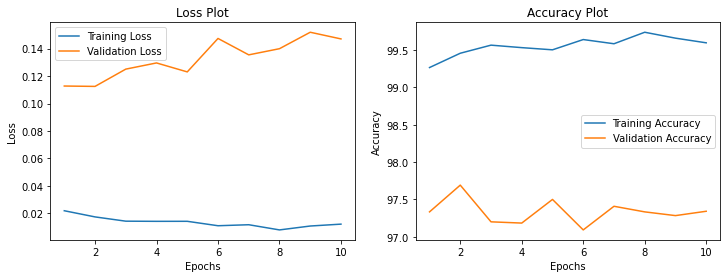

In [ ]:
plotLoss_Accuracy(m5_loss_sch2, epoch=10)

In [ ]:
from tabulate import tabulate
print(tabulate([['Train Loss', m5_loss[0][epochs-1], m5_loss_sch1[0][epochs-1], m5_loss_sch2[0][epochs-1]], 
                  ['Valid Loss', m5_loss[1][epochs-1], m5_loss_sch1[1][epochs-1], m5_loss_sch2[1][epochs-1]], 
                    ['Test Loss', m5_testLoss[0], m5_Testloss_sch1[0], m5_Testloss_sch2[0]], 
                      ['Train Accuracy', m5_loss[2][epochs-1], m5_loss_sch1[2][epochs-1], m5_loss_sch2[2][epochs-1]], 
                        ['Valid Accuracy', m5_loss[3][epochs-1], m5_loss_sch1[3][epochs-1], m5_loss_sch2[3][epochs-1]], 
                          ['Test Accuracy', m5_testLoss[1], m5_Testloss_sch1[1], m5_Testloss_sch2[1]]], 
                            headers=['Loss & Accuracy', 'Model without Scheduler', 'Model with MultiplicativeLR Scheduler', 'Model with LinearLR Scheduler']))

Loss & Accuracy      Model without Scheduler    Model with MultiplicativeLR Scheduler    Model with LinearLR Scheduler
-----------------  -------------------------  ---------------------------------------  -------------------------------
Train Loss                         0.0221988                                0.0235307                        0.0120252
Valid Loss                         0.113836                                 0.112555                         0.147103
Test Loss                          0.102875                                 0.0894548                        0.121809
Train Accuracy                    99.2833                                  99.25                            99.5979
Valid Accuracy                    97.2417                                  97.3333                          97.3417
Test Accuracy                     97.55                                    97.65                            97.67


### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [ ]:
import torch
import torch.nn as nn

class SimpleMLP_BN(nn.Module):

    def __init__(self):
        super(SimpleMLP_BN,self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self,x):
        x = x.view(-1, 784)
        output = torch.relu(self.bn1(self.fc1(x)))
        output = torch.relu(self.bn2(self.fc2(output)))
        output = self.fc3(output)
        return output


In [ ]:
modelBN1 = SimpleMLP_BN().to(device)

In [ ]:
import torch.nn as nn

class SimpleMLP_Dropout(nn.Module):

    def __init__(self, dropout_rate=0.2):
        super(SimpleMLP_Dropout, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = x.view(-1, 784)
        output = torch.relu(self.fc1(x))
        output = self.dropout(output)
        output = torch.relu(self.fc2(output))
        output = self.dropout(output)
        output = self.fc3(output)
        return output


In [ ]:
modelDropout1 = SimpleMLP_Dropout().to(device)

In [ ]:
import torch
import torch.nn as nn

class SimpleMLP_BN_Dropout(nn.Module):

    def __init__(self, dropout_rate=0.2):
        super(SimpleMLP_BN_Dropout, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        output = torch.relu(self.fc1(x))
        output = self.bn1(output)
        output = self.dropout(output)
        output = torch.relu(self.fc2(output))
        output = self.bn2(output)
        output = self.dropout(output)
        output = self.fc3(output)
        return output


In [ ]:
model_BN_Dropout = SimpleMLP_BN_Dropout().to(device)

### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

In [ ]:
AdamOptimizer2 = Adam_optimizer(modelBN1, 0.001)

In [ ]:
modelBN1_loss = train_Model(modelBN1, AdamOptimizer2, epochs)

Training Loss:  0.023398649182675094 	Validation Loss:  0.08849535922846816
Train Accuracy: 99.18958282470703 	Validation Accuracy: 97.5999984741211



In [ ]:
modelBN1_testloss = test_Model(modelBN1)

Test Loss: 0.07105827602078829 Test Accuracy: 98.07999420166016


In [ ]:
table(modelBN1_loss, modelBN1_testloss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0233986           99.1896          0.0884954                   97.6    0.0710583            98.08           1


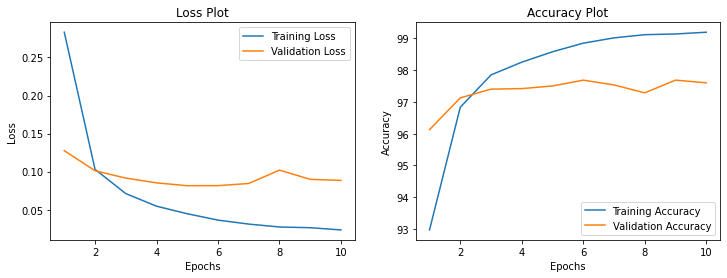

In [ ]:
plotLoss_Accuracy(modelBN1_loss, epoch=10)

In [ ]:
AdamOptimizer3 = Adam_optimizer(modelDropout1, 0.001)

In [ ]:
modelDropout1_loss = train_Model(modelDropout1, AdamOptimizer3, epochs)

Training Loss:  0.060846203583603105 	Validation Loss:  0.09146631935808283
Train Accuracy: 98.03125 	Validation Accuracy: 97.53333282470703



In [ ]:
modelDropout1_testloss = test_Model(modelDropout1)

Test Loss: 0.06967057385200125 Test Accuracy: 97.79000091552734


In [ ]:
table(modelDropout1_loss, modelDropout1_testloss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0608462           98.0312          0.0914663                97.5333    0.0696706            97.79           1


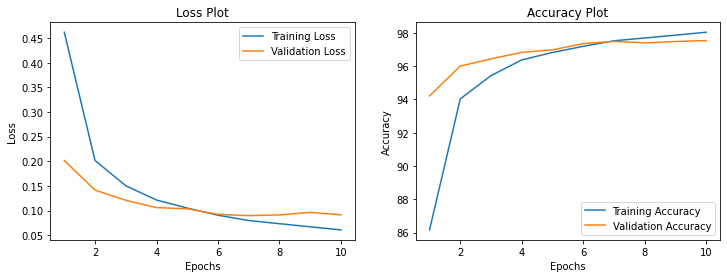

In [ ]:
plotLoss_Accuracy(modelDropout1_loss, epoch=10)

In [ ]:
AdamOptimizer4 = Adam_optimizer(model_BN_Dropout, 0.001)

In [ ]:
model_BN_Dropout_loss = train_Model(model_BN_Dropout, AdamOptimizer4, epochs)

Training Loss:  0.06905818963547547 	Validation Loss:  0.08735202161714117
Train Accuracy: 97.70416259765625 	Validation Accuracy: 97.57500457763672



In [ ]:
model_BN_Dropout_testloss = test_Model(model_BN_Dropout)

Test Loss: 0.06901026528794318 Test Accuracy: 97.88999938964844


In [ ]:
table(model_BN_Dropout_loss, model_BN_Dropout_testloss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
      0.0690582           97.7042           0.087352                 97.575    0.0690103            97.89      0.9375


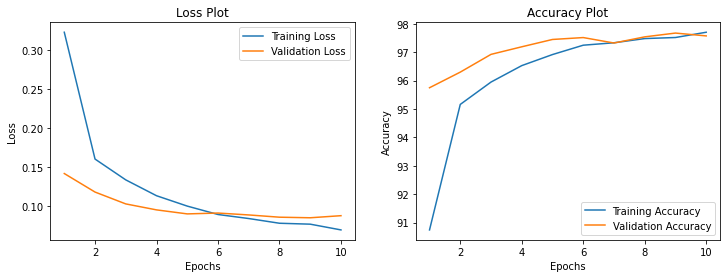

In [ ]:
plotLoss_Accuracy(model_BN_Dropout_loss, epoch=10)

### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!

In [ ]:
def train_Model_Stocastic(model, optimizer, epochs):
  
  result = []
  
  trainloss_list = []
  validloss_list = []
  trainAcc_list = []
  validAcc_list = []

  for epoch in range(epochs):
      train_loss=0.0
      valid_loss=0.0
      train_accurate = 0
      valid_accurate = 0

      # training phase
      model.train()
      for images, labels in trainloader_stochastic:
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          optimizer.zero_grad()
          output = model(images)
          loss = criterion(output,labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          pred1 = output.argmax(dim=1)
          train_accurate += torch.sum((pred1==labels).int())

      # validation phase
      model.eval()
      for images, labels in validloader_stochastic:
          if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          output = model(images)
          loss = criterion(output,labels)
          valid_loss += loss.item()
      
          pred2 = output.argmax(dim=1)
          valid_accurate += torch.sum((pred2==labels).int())

      Accuracy_train = 100 * (train_accurate/len(train_sampler))
      Accuracy_valid = 100 * (valid_accurate/len(valid_sampler))

      train_loss = train_loss/len(trainloader_stochastic)
      valid_loss = valid_loss/len(validloader_stochastic)

      trainloss_list.append(train_loss)
      validloss_list.append(valid_loss)
      trainAcc_list.append(Accuracy_train)
      validAcc_list.append(Accuracy_valid)

  print("Training Loss: ", train_loss ,"\tValidation Loss: ", valid_loss)
  print(f'Train Accuracy: {Accuracy_train} \tValidation Accuracy: {Accuracy_valid}\n')

  result.extend([trainloss_list, validloss_list, trainAcc_list, validAcc_list])
  return result

In [ ]:
def test_Model_Stocastic(model):
    correct = 0
    test_loss = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    result = []

    model.eval()
    test_accurate = 0
    for images, labels in testloader_stochastic:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = criterion(output,labels)
            test_loss += loss.item()
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(labels.data.view_as(pred)))


            pred = output.argmax(dim=1)
            test_accurate += torch.sum((pred==labels).int())

    test_loss = test_loss/len(testloader_stochastic)
    Accuracy_test = 100 * (test_accurate/len(testset))

    print(f'Test Loss: {test_loss} Test Accuracy: {Accuracy_test}')
    f1score = f1_score(labels, pred, average='weighted')

    result.extend([test_loss, Accuracy_test, f1score])
    return result

In [ ]:
model_St = SimpleMLP().to(device)

In [ ]:
AdamOptimizer5 = Adam_optimizer(model_St, 0.001)

In [ ]:
model_St_loss = train_Model_Stocastic(model_St, AdamOptimizer5, epochs)

Training Loss:  0.10375878193541875 	Validation Loss:  0.3344444789234
Train Accuracy: 97.79582977294922 	Validation Accuracy: 96.10000610351562



In [ ]:
model_St_testloss = test_Model_Stocastic(model_St)

Test Loss: 0.29553815429910624 Test Accuracy: 96.02000427246094


In [ ]:
table(model_St_loss, model_St_testloss)

  Training Loss    Train Accuracy    Validation Loss    Validation Accuracy    Test Loss    Test Accuracy    F1 Score
---------------  ----------------  -----------------  ---------------------  -----------  ---------------  ----------
       0.103759           97.7958           0.334444                   96.1     0.295538            96.02           1


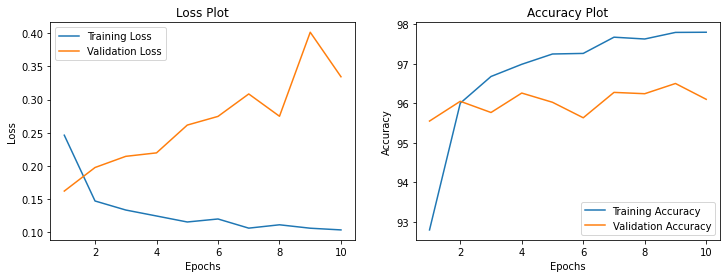

In [ ]:
plotLoss_Accuracy(model_St_loss, epoch=10)

In [ ]:
from tabulate import tabulate
print(tabulate([['Train Loss', m5_loss[0][epochs-1], model_St_loss[0][epochs-1]], 
                  ['Valid Loss', m5_loss[1][epochs-1], model_St_loss[1][epochs-1]], 
                    ['Test Loss', m5_testLoss[0], model_St_testloss[0]], 
                      ['Train Accuracy', m5_loss[2][epochs-1], model_St_loss[2][epochs-1]], 
                        ['Valid Accuracy', m5_loss[3][epochs-1], model_St_loss[3][epochs-1]], 
                          ['Test Accuracy', m5_testLoss[1], model_St_testloss[1]]], 
                            headers=['Loss & Accuracy', 'Stochastic Model', 'MiniBatch Model']))

Loss & Accuracy      Stochastic Model    MiniBatch Model
-----------------  ------------------  -----------------
Train Loss                  0.0221988           0.103759
Valid Loss                  0.113836            0.334444
Test Loss                   0.102875            0.295538
Train Accuracy             99.2833             97.7958
Valid Accuracy             97.2417             96.1
Test Accuracy              97.55               96.02
